In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('cement_slump.csv')

In [3]:
df.head()

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Cement                              103 non-null    float64
 1   Slag                                103 non-null    float64
 2   Fly ash                             103 non-null    float64
 3   Water                               103 non-null    float64
 4   SP                                  103 non-null    float64
 5   Coarse Aggr.                        103 non-null    float64
 6   Fine Aggr.                          103 non-null    float64
 7   SLUMP(cm)                           103 non-null    float64
 8   FLOW(cm)                            103 non-null    float64
 9   Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(10)
memory usage: 8.2 KB


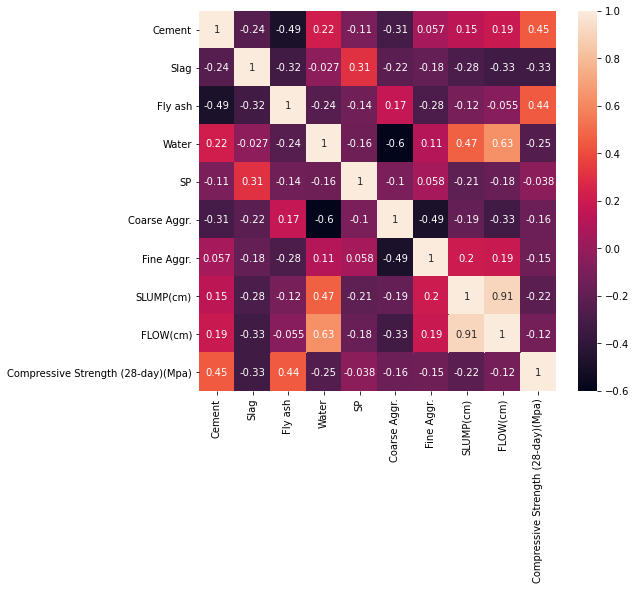

In [7]:
plt.figure(figsize=(8,7))
sns.heatmap(df.corr(),annot=True);

In [8]:
X = df.drop('Compressive Strength (28-day)(Mpa)',axis=1)

In [9]:
y = df['Compressive Strength (28-day)(Mpa)']

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#### So recall SVM uses distance as a key factor so it is better to scale the data 

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()

In [14]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

Now performing SVM for regression has few option in scikit-learn:-
1. SVR - the most generic version of Support Vector Regression.
2. And then we have LinearSVR - which provides a faster version of support vector regression, the only catch/caveat is that it only considers kernel='linear' i.e. a linear kernel.  So if you know beforehand that you will be using a linear kernel, you should use LinearSVR, as it can perform fater mathematical computation, compared to normal SVR.

However, if you want to explore the options of different kernels, such as the radial basis function, then you'll have to use SVR.

In [16]:
from sklearn.svm import SVR, LinearSVR

In [18]:
#help(SVR)

In [20]:
# Let'se just use a base SVR model with all default hyperparameter values and see how it perfroms.
base_model = SVR()

In [21]:
base_model.fit(scaled_X_train,y_train)

SVR()

In [22]:
base_preds = base_model.predict(scaled_X_test)

In [46]:
base_model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [26]:
#evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [24]:
# the answer of this is in mega pascals
mean_absolute_error(y_test, base_preds)

5.236902091259178

In [25]:
np.sqrt(mean_squared_error(y_test, base_preds))

6.695914838327133

In [27]:
y_test.mean()

36.26870967741935

In [28]:
base_preds.mean()

36.02167745068362

In [29]:
r2_score(y_test, base_preds)

0.34523422389221803

### So now what we wanna find out is that can we improve this using gridsearch and find best parameters that find best results for us.

In [35]:
parameter_grid = {'C':[0.001,0.01,0.1,0.5,1], 'kernel':['linear','rbf','poly'],
                 'gamma':['scale','auto'], 'degree':[2,3,4],
                 'epsilon':[0,0.01,0.1,0.5,1,2]}

1. Here we have gamma because we are using rbf kernel
2. We are using degree because we are using poly kernel
3. Epsilon value denotes the amout of error we are allowing to be there.

Note that here some of the paramters don't match up with others like gamma does not relate to linear kernel so we'll get warning which is acceptable.

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
svr = SVR()

In [38]:
grid_model = GridSearchCV(estimator=svr, param_grid=parameter_grid)

In [39]:
grid_model.fit(scaled_X_train, y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1], 'degree': [2, 3, 4],
                         'epsilon': [0, 0.01, 0.1, 0.5, 1, 2],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']})

In [40]:
grid_model.best_estimator_

SVR(C=1, degree=2, epsilon=2, kernel='linear')

So here we can see that the model selected C/regularization as 1, degree as 3 as allowed error/epsilon = 2 and a linear kernel. So in all it selected a relatively simple model.

In [48]:
grid_model.best_estimator_.get_params()

{'C': 1,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 2,
 'epsilon': 2,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

#### Now let's see if this performs better than the previously selected model.

In [42]:
grid_preds = grid_model.predict(scaled_X_test)

In [43]:
#evaluation
mean_absolute_error(y_test, grid_preds)

2.5128012210762365

In [44]:
np.sqrt(mean_squared_error(y_test, grid_preds))

3.178210305119858

In [45]:
r2_score(y_test, grid_preds)

0.8524866277808405

### So we can se that definitely the second model is the best one as we scaled the data and chose the best parameters with gridsearch.

So definitely when it comes to support vectors, both for classification and regression, you should be both scaling your data and performing a cross validation and a grid search for the best parameters.

In [56]:
pd.DataFrame({'basemodel': pd.Series(base_model.get_params()), 'gridmodel': pd.Series(grid_model.best_estimator_.get_params())})

,basemodel,gridmodel
C,1,1
cache_size,200,200
coef0,0,0
degree,3,2
epsilon,0.1,2
gamma,scale,scale
kernel,rbf,linear
max_iter,-1,-1
shrinking,True,True
tol,0.001,0.001


#### So here we can see side by side what the best paramters were chosen by the grid search over the base model.